In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [6]:
x, y = torch.load('/home/asadsolo/Downloads/MNIST/processed/training.pt')
x.shape

torch.Size([60000, 28, 28])

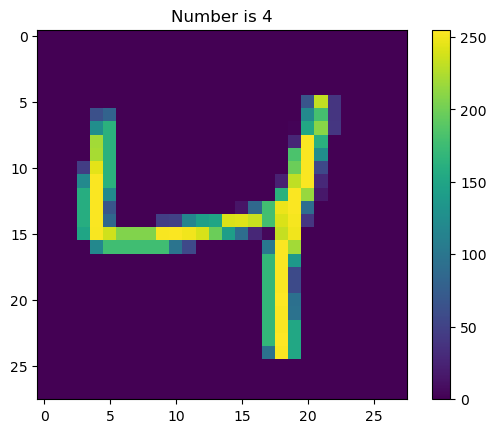

In [7]:
plt.imshow(x[2].numpy())
plt.title(f'Number is {y[2].numpy()}')
plt.colorbar()
plt.show()

## One Hot Enconder

In [8]:
y_original = torch.tensor([2, 4, 3, 0, 1])

In [10]:
F.one_hot(y_original)

tensor([[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0]])

In [11]:
y_original = torch.tensor([2, 4, 3, 0, 1])
y_new = F.one_hot(y_original)

In [13]:
y_original

tensor([2, 4, 3, 0, 1])

In [14]:
y_new

tensor([[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0]])

In [16]:
y.shape

torch.Size([60000])

In [17]:
y_new = F.one_hot(y, num_classes = 10)
y_new

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])

In [20]:
y_new.shape

torch.Size([60000, 10])

## Images with SHapes

In [21]:
x.shape

torch.Size([60000, 28, 28])

In [23]:
x.view(-1, 28**2).shape

torch.Size([60000, 784])

## Pytorch Dataset Object

In [36]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255.
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [37]:
train_ds = CTDataset('/home/asadsolo/Downloads/MNIST/processed/training.pt')
test_ds = CTDataset('/home/asadsolo/Downloads/MNIST/processed/test.pt')

In [38]:
len(train_ds)

60000

In [39]:
xs, ys = train_ds[0:4]

In [42]:
xs.shape

torch.Size([4, 28, 28])

In [43]:
ys.shape

torch.Size([4, 10])

## PyTorch DataLoader Object

In [44]:
train_dl = DataLoader(train_ds, batch_size=5)

In [45]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([5, 28, 28])
torch.Size([5, 10])


In [46]:
len(train_dl)

12000

## Cross Entropy Loss

In [48]:
L = nn.CrossEntropyLoss()

## The Network

In [50]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2, 100)
        self.Matrix2 = nn.Linear(100, 50)
        self.Matrix3 = nn.Linear(50,10)
        self.R = nn.ReLU()
    def forward(self, x):
        x = x.view(-1, 28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

In [52]:
f = MyNeuralNet()

In [53]:
xs.shape

torch.Size([4, 28, 28])

In [54]:
f(xs)

tensor([[ 0.0854,  0.1423, -0.0516,  0.0718, -0.0597, -0.1385,  0.0983, -0.0307,
          0.0282,  0.0951],
        [ 0.0526,  0.1359, -0.0873,  0.0342, -0.0359, -0.1872,  0.0885, -0.0339,
          0.0640,  0.0516],
        [ 0.0841,  0.1343, -0.0792,  0.0238, -0.0754, -0.1700,  0.1166, -0.0163,
          0.0320,  0.0982],
        [ 0.0587,  0.0848, -0.1094,  0.0556, -0.0538, -0.1753,  0.1559, -0.0010,
          0.0129,  0.1103]], grad_fn=<SqueezeBackward0>)

In [55]:
ys ##this is what it should eventually be equal to using SGD and Loss function we defined

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [57]:
f(xs).shape

torch.Size([4, 10])

In [59]:
L(f(xs), ys)

tensor(2.3411, dtype=torch.float64, grad_fn=<DivBackward1>)

## Training

In [63]:
def train_model(dl, f, n_epochs = 20):
    #Optimization
    opt = SGD(f.parameters(), lr = 0.01)
    L = nn.CrossEntropyLoss()
    
    #Train Model
    losses =[]
    epochs=[]
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(dl)
        for i, (x, y) in enumerate(dl):
            #Update the weights of the network
            opt.zero_grad()
            loss_value = L(f(x), y)
            loss_value.backward()
            opt.step()
            #Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [64]:
epoch_data, loss_data = train_model(train_dl, f)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Cross Entropy (per batch)')

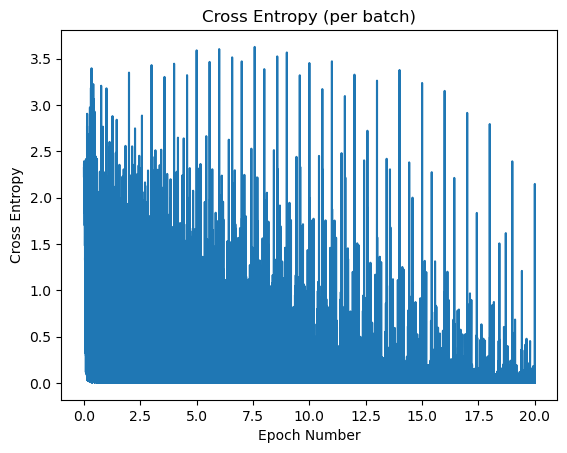

In [66]:
plt.plot(epoch_data, loss_data)
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (per batch)')

In [67]:
loss_data.reshape(20, -1).shape

(20, 12000)

In [68]:
epoch_data_avgd = epoch_data.reshape(20, -1).mean(axis =1)
loss_data_avgd = loss_data.reshape(20, -1).mean(axis=1)

Text(0.5, 1.0, 'Cross Entropy (avgd per epoch)')

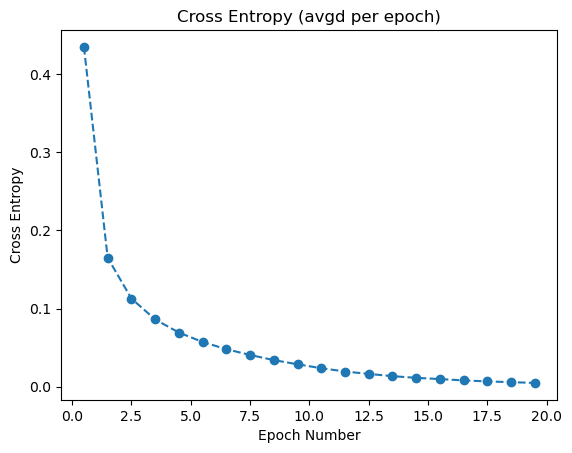

In [69]:
plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')

In [71]:
train_ds[0]

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000,

In [72]:
y_sample = train_ds[0][1]
y_sample

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)

In [73]:
x_sample = train_ds[0][0]
yhat_sample = f(x_sample)
yhat_sample

tensor([ -6.1279,   5.1087,  -6.1859,  24.0136, -28.3864,  30.1161,  -8.5097,
         -4.9869,  -1.8783,  -0.9154], grad_fn=<SqueezeBackward0>)

In [74]:
torch.argmax(yhat_sample)

tensor(5)

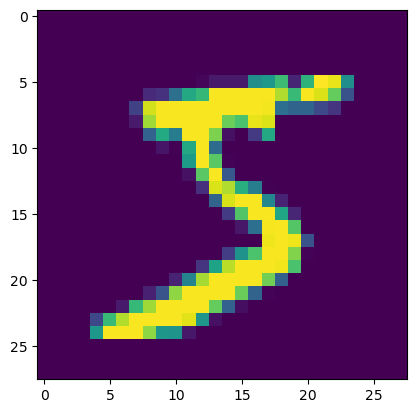

In [75]:
plt.imshow(x_sample)

In [76]:
xs, ys = train_ds[0:2000]

In [77]:
xs.shape

torch.Size([2000, 28, 28])

In [78]:
ys.shape

torch.Size([2000, 10])

In [79]:
yhats = f(xs).argmax(axis = 1)

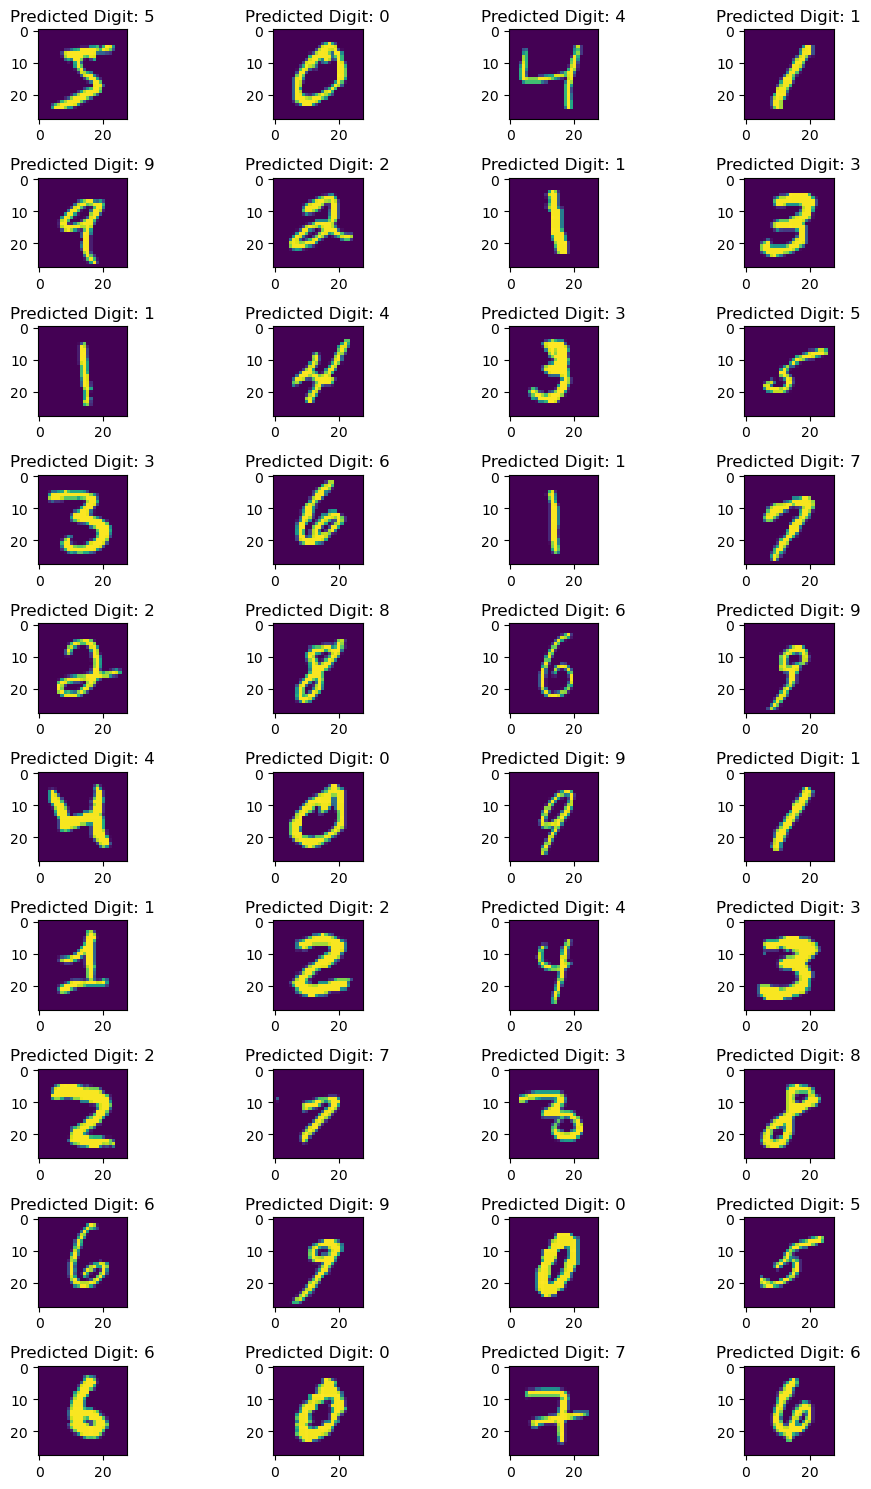

In [81]:
fig, ax = plt.subplots(10, 4, figsize = (10, 15))
for i in range(40):
    plt.subplot(10, 4, i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()

In [82]:
xs, ys = test_ds[:2000]
yhats = f(xs).argmax(axis = 1)

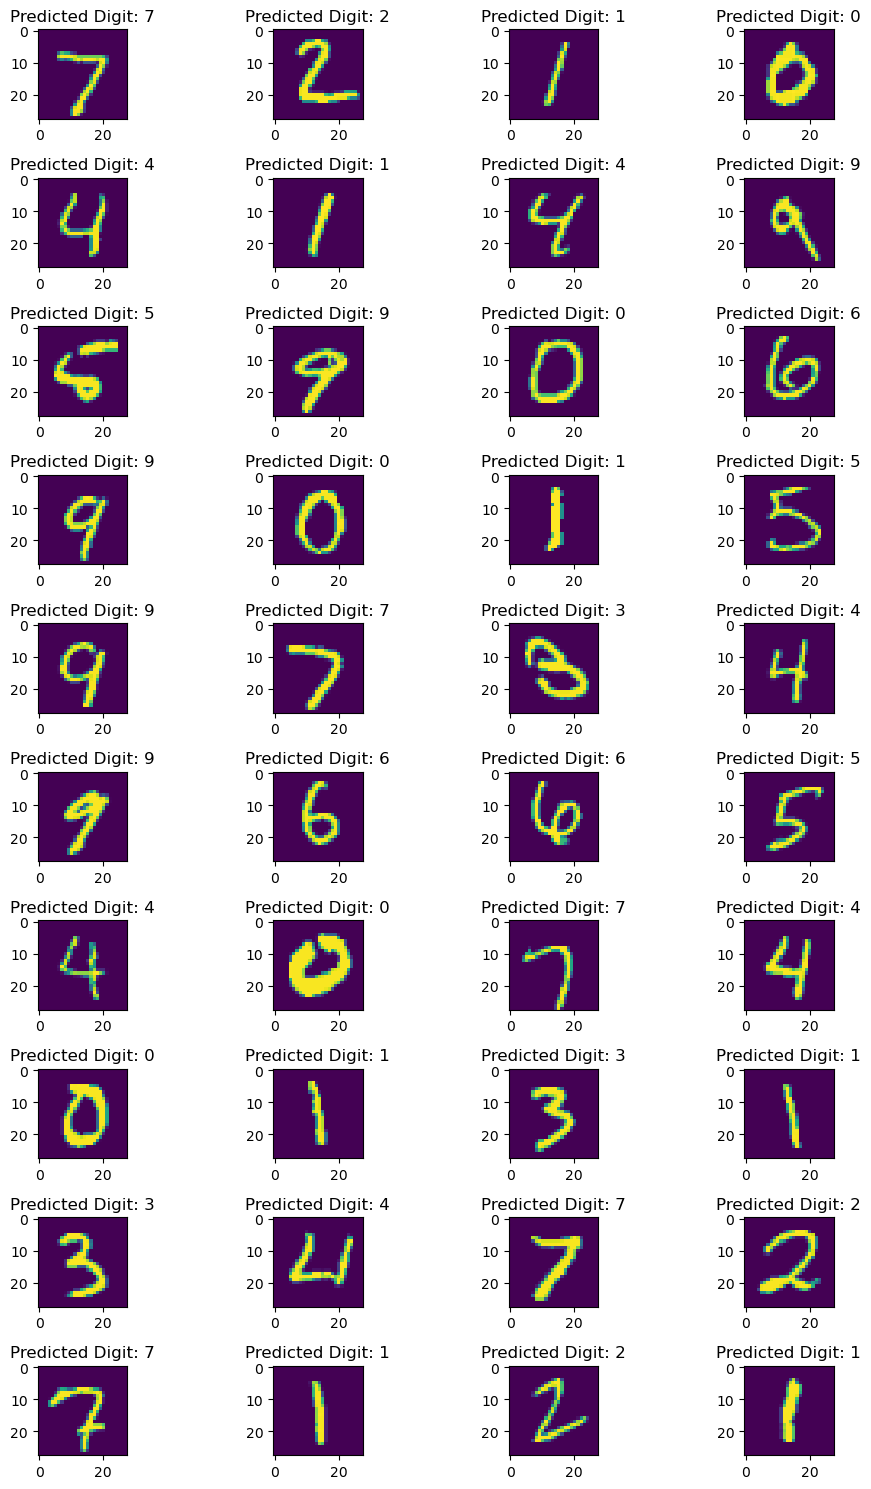

In [83]:
fig, ax = plt.subplots(10, 4, figsize =(10, 15))
for i in range(40):
    plt.subplot(10, 4, i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()